[![Open In Colab](./colab-badge.png)](https://colab.research.google.com/github/MooseNeuro/moose-notebooks/blob/main/Getting_started_with_compartmental_modelling_in_MOOSE.ipynb)

# Getting started with compartmental modelling in MOOSE

## Author: Subhasis Ray
### Created: 2023-12-15

## Install pymoose with `pip`
The python module for `moose` is called `pymoose`. It is available on PyPi, so you can install it using `pip`

In [1]:
# !pip install pymoose  # required on colab

## Modelling a small section of a neuron

![A passive neuronal compartment](https://moose.ncbs.res.in/readthedocs/_images/neuronalcompartment.jpg)

A compartment models the electrical properties of a little piece of a neuron.
Neurons are animal cells, and thus eukaryotic. The outermost layer of such a cell is usually the *cell membrane* (some neurons also have another layer called myelin sheath outside the cell membrane, but we shall keep that for later).

The cell membrane is made of two layers of fat or lipid, called the *lipid bilayer*. Its thickness and other physcial properties are quite standard across cell types. An insulator separating conductors with a voltage difference between them is a capacitor (Cm). But the cell membrane is more than just an insulator. It has many channels that allow charge-carrying ions to move between the cytoplasm and the external medium. The moving ions face resistance in their movement, which can be modeled as a resistor (Rm). In addition, there is a potential difference between the cytoplasm (inside the cell) and the external medium (outside the cell).

Experimenters often conduct current clamp experiments to characterize a neuron. They insert an electrode into the cell, and then pass a constant current for some time through the electrode. There is a special kind of electrical circuit (a constant current-source) that changes the voltage at the terminal connected to the electrode to maintain a constant current flowing through it. This is usually stated as injecting a constant current into the cell.

The membrane resistance and capacitance provide two alternate paths for electricity, making it equivalent to a parallel RC circuit, i.e., a circuit where a resistor and a capator are connected in parallel. The current splits between these two components.

## Parallel RC Circuit
In a parallel connection of a resistor $R$ and a capacitor $C$ the two components have the same voltage between their terminals.

Now, for a capacitor of capacitance $C$ with voltage $V$ across it, the total electric charge across it is

$q = CV$

Electric current is the rate of flow of charge, which is the derivative of charge with respect to time:

$\frac{dq}{dt} = C \frac{dV}{dt}$ since $C$ is constant (a property of the capacitor),

or $i_{C} = C \frac{dV}{dt}$

By Ohm's law, if the current through the resistor is $i_{R}$, then

$V = i_{R} R$

or $i_{R} = \frac{V}{R}$

Thus, the total current through both the components would be

$i = i_{R} + i_{C}$

$i = \frac{V}{R} + C \frac{dV}{dt}$


$\frac{dV}{dt} = \frac{1}{C}(i - \frac{V}{R})$

This is a first order ordinary differential equation (ODE). In a current clamp experiment we inject a constant current $i$ into the cell, and the differential equation can be solved to find the evolution of voltage $V$ over time for a given current. This equation has an analytical solution, and can also be easily solved numerically.

The denominator of $V$ on the right hand side is $RC$ which determines how fast the capacitor gets charged or discharged. This is called the time constant, and is denoted by $\tau$.

*In electronics/electrical engineering resistors, capacitors, inductors, and memristors are called passive components. Thus the model of the cell membrane using only a resistor and a capacitor is called the <b>passive membrane</b>*

## Solving the passive membrane equation in Python
The `scipy` module in Python provides several functions for solving ODEs. The recommended method for this kind of problem is [`scipy.integrate.solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp). `ivp` stands for initial value problem, where we can set the initial values of the parameter(s) of our ODE, and then compute how they evolve with time (the independent variable).

The function signature is: `scipy.integrate.solve_ivp(fun, t_span, y0, ...)`

Here `fun` must be a function with signature `fun(t, y)` where `y` is the dependent variable (in our case $V$) and `t` is the independent variable (time). This function must return the value of $\frac{dy}{dt}$ at time $t$. $y0$ is the initial value of $y$, i.e., its value at time $t = t_{0}$ ($t_{0} = 0$ if we start our clock at that moment).

Now, we could translate the equation above to this function

```python
def dv_dt(t, v):
  """function returning the value of dV/dt
  at time t and current voltage v"""
  return (i - v/R)/C

```
However, there is a problem. How would our function know the value of `i`, `R` and `C`?
One possibility is to keep them as global constants in our script.

We can set $R$ to $10 kS$ and $C$ to $0.1 \mu F$ which will give a time constant of $\tau = RC = 1 ms$. We can test this circuit by injecting $1 \mu A$ current into it.

In Neuroscience literature `Vm` commonly represents the membrane voltage
i.e., the potential difference between the cytoplasm and the extracellular medium. In many mammalian neurons this has a value around -70 mV when the cell is in the resting state.

In [2]:
R = 1e4     # 10 kS
C = 1e-7   # 0.10 uF
i = 1e-6    # 1 uA
V0 = -70e-3  # -70 mV

def dv_dt(t, Vm):
  """function returning the value of dV/dt
  at time t and current voltage v"""
  return (i - Vm/R)/C

Now we need to import `scipy`'s `solve_ivp` function, and call it with the function `dv_dt` along with the initial membrane voltage `V0`, range of time $t$ (`t_span`) and the time points at which we want the value of Vm (`t_eval`).

Note that we have to pass V0 inside a list because `solve_ivp` expects a 1 dimensional array, not a scalar for the `y0` parameter.

In [3]:
import numpy as np
from scipy.integrate import solve_ivp


# Calculate the values of V for 10 ms
t_span = (0, 10e-3)
# Return the values from 0 to 10 ms at 0.1 ms interval
t_eval = np.arange(*t_span, 0.1e-3)
# Initial value of V can be -70 mV, frequently
# found resting membrane potential in mammalian neurons
result = solve_ivp(fun=dv_dt, t_span=t_span, y0=[V0], t_eval=t_eval)

Now `result` contains the object returned by `solve_ivp`. The attributes of use to us are `t`, the time points at which the solver computed the value of our variable, and `y`, the corresponding values. Also, `result.y` is a 2D array where each row represents the values of one dependent variable. We have only one, Vm, so we have to take out the first (and only) row `y[0]` for plotting against `t`.

Text(0, 0.5, 'Voltage (mV)')

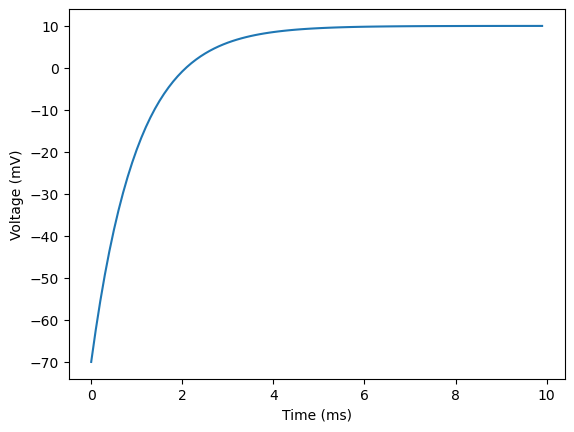

In [4]:
import matplotlib.pyplot as plt


# Note that we are changing the units for a cleaner plot
#
plt.plot(result.t*1e3, result.y[0]*1e3)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

**You should play with the values of $R$ and $C$ to understand how their product affects the steepness of the curve.**

## `scipy` to `MOOSE`
A neuron has a complex morphology, and each little section is implemented as a compartment. Different compartments may have different total resistance and capacitance. Electric current flows from compartment to compartment. The approach using ODE solvers directly gets out of hand very quickly.

MOOSE provides a more natural way of setting up complex models with objects that correspond to the biological entities, and hides the details of setting up the ODEs from the user.

### Import moose to use its classes and functions

In [5]:
import moose

### `le()` function lists the elements available.
The output looks similar to directory listing on Unix systems. `/` is the root element, everything else is created under this. There are a bunch of elements that already exist. These elements are not for the user, but used by MOOSE for managing the infrastructure underlying the models and simulations.

In [6]:
moose.le()

Elements under /
    /Msgs
    /clock
    /classes
    /postmaster



### It is good practice to separate your model from data
So we create an element `/data` for containing the data tables and another element `model` for containing the model structure. These are of the class `Neutral`, which is simply a container without any simulation related function.

In [7]:
data = moose.Neutral('/data')
model = moose.Neutral('/model')

In [8]:
compartment = moose.Compartment('/model/compartment')

### Set the properties of the compartment

We have to set the numerical values for these properties before we can use it for  simulations that make physiological sense.

But what are these properties?

These are available as fields of the compartment object. We can see a list of available fields in the compartment object using the `getFieldNames` function:

In [9]:
moose.getFieldNames('Compartment')

['this',
 'name',
 'me',
 'parent',
 'children',
 'path',
 'className',
 'numData',
 'numField',
 'idValue',
 'index',
 'fieldIndex',
 'tick',
 'dt',
 'valueFields',
 'sourceFields',
 'destFields',
 'msgOut',
 'msgIn',
 'Vm',
 'Cm',
 'Em',
 'Im',
 'inject',
 'initVm',
 'Rm',
 'Ra',
 'diameter',
 'length',
 'x0',
 'y0',
 'z0',
 'x',
 'y',
 'z',
 'coords']

In [10]:
compartment.valueFields

['this',
 'name',
 'me',
 'parent',
 'children',
 'path',
 'className',
 'numData',
 'numField',
 'idValue',
 'index',
 'fieldIndex',
 'tick',
 'dt',
 'valueFields',
 'sourceFields',
 'destFields',
 'msgOut',
 'msgIn',
 'Vm',
 'Cm',
 'Em',
 'Im',
 'inject',
 'initVm',
 'Rm',
 'Ra',
 'diameter',
 'length',
 'x0',
 'y0',
 'z0',
 'x',
 'y',
 'z',
 'coords']

We can set the initial value of the membrane voltage `initVm` to the resting value $-70 mV$.

In [11]:
moose.showfield(compartment)


[/model[0]/compartment[0]]
name          = compartment
className     = Compartment
tick          = 3
dt            = 5e-05
Cm            = 1.0
Em            = -0.06
Im            = 0.0
Ra            = 1.0
Rm            = 1.0
Vm            = -0.06
diameter      = 0.0
initVm        = -0.06
inject        = 0.0
length        = 0.0
x             = 0.0
x0            = 0.0
y             = 0.0
y0            = 0.0
z             = 0.0
z0            = 0.0



In [12]:
compartment.initVm = -70e-3

For the simulation corresponding to the above example, we set $Rm$ to 10 $k\Omega$, $Cm$ to 0.1 $\mu$F and injection current 1 $\mu$A.


In [13]:
compartment.Rm = 1e4
compartment.Cm = 1e-7
compartment.inject = 1e-6

### Setup recording and run the simulation
In moose the data get stored in objects of the `Table` class. We connect a table to a field whose values we want to record. As the simulation progresses, the computed value gets appended to the connected table.

In [14]:
vm_tab = moose.Table('/data/Vm')
moose.connect(vm_tab, 'requestOut', compartment, 'getVm')

<moose.SingleMsg id=5 dataIndex=0 path=/Msgs[0]/singleMsg[0]>

Here the first line creates a table called `Vm` under the `/data` element. Most MOOSE classes allow communication between different objects via something called `message fields`. The `requestOut` field of `vm_tab` is connected to the `getVm` field of `compartment`.

`vm_tab` has an associated `dt` field for the time interval at which it gets the `Vm` sample from `compartment`.

#### *NOTE*
*The above cell should be executed exactly once. You may modify the parameters, like*

```
compartment.initVm = -70e-3
compartment.Rm = 1e4
compartment.Cm = 1e-7
compartment.inject = 1e-6
```

*as many times as you wish and rerun the steps below to simulate the modified model. But the `moose.connect(source_element, source_message, target_element, target_message)` changes the stucture of the model, and you should avoid that unless you know what you are doing.*


### Initialize and run the simulation
Now we can tell moose to initialize all parameters to default or specified initial values (e.g., `initVm` of compartment will be assigned to `Vm`) using the `reinit()` function, and then start simulation for a specified runtime.

In [15]:
runtime = 10e-3  # simulate 10 ms
moose.reinit()
moose.start(runtime)

The `start(runtime)` function will run the simulation for `runtime` time, and at each timestep the table `vm_tab` will get the calculated value of `Vm`. The underlying array of `Vm` values can be accessed like a numpy array via the attribute `vector` of the `Table` object (`vm_tab`).

How about the time points? As mentioned earlier, successive timepoints of recording `Vm` are `vm_tab.dt` apart, i.e.,


$t_{0} = 0$

$t_{1} = dt$

$t_{2} = 2 dt$

$t_{3} = 3 dt$

...

$t_{n-1} = (n - 1) dt$


So we can compute the time points (starting from 0) by multiplying the index of the data point by `dt`:
```
# numpy's arange(n) creates an array numbers containing 0 to (n-1)
t = np.arange(len(Vm)) * vm_tab.dt
```

In [16]:
print('compartment dt',compartment.dt)
print('table dt',vm_tab.dt)

compartment dt 5e-05
table dt 0.0001


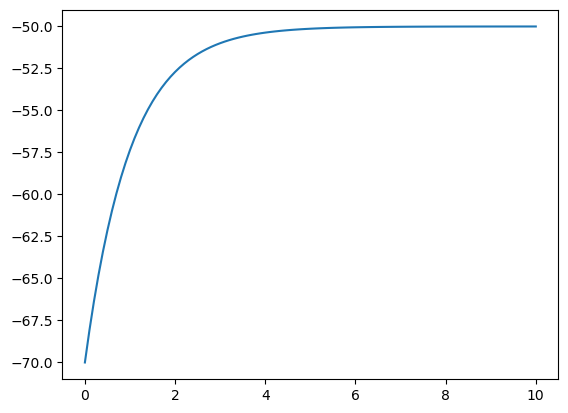

In [17]:
Vm = vm_tab.vector
t = np.arange(len(Vm)) * vm_tab.dt
plt.plot(t * 1e3, Vm * 1e3)

## Exercises
1. Change the value of $initVm$ to 0 mV and rerun the simulation. What change to you observe?
1. Change the magnitude of the injected current, make it 10 times larger or smaller. What are the effects?
1. Modify the values of $Rm$ and $Cm$ and rerun the simulation. How do they affect the voltage curve?
1. Double $Rm$ and halve $Cm$ and simulate again. Does the curve change? What do you conclude from this?

## A more realistic approach

When modelling closely with experimental data, one obtains the geometric structure (morphology) of neurons by tracing dye-filled neurons under a microscope. This data is then processed to estimate the length and diameter of compartments. Modellers often use constant specific capacitance on all the compartments (as we mentioned earlier, this is pretty standard for all cell membranes), and often a constant specific resistance (resistivity) for all, or groups of, compartments. This requires calculating the total resistance and capacitance for each compartment based on its dimensions.

Let us say the length of the compartment is 10 μm and the diameter is also 10 μm

In [18]:
compartment.length = 10e-6
compartment.diameter = 10e-6

However, these are not used in the electrical simulation, but are used for visualization. The electrical properties `Rm` and `Cm` determine the behavior of the neuron in response to electric current. These are absolute, not specific values, in MOOSE.

All eukaryotic cell membranes are made of lipid bilayer, and this has a specific capacitance of about $1 \mu F/cm^2$.

The total capacitance of a cylindrical compartment will be $area \times specific\; capacitance$

In [22]:
specific_cm = 1e-6/(1e-2)**2
compartment.Cm = 3.1416 * compartment.diameter * compartment.length * specific_cm
print(compartment.Cm)

3.1416e-12


Note that we converted the $\mu F/cm ^{2}$ to $F/m^{2}$ in order to have consistent SI units throughout. In electrophysiology experiments people often report measured capacitance in $nF$ (nanoFarads, $10^{-9} F$) or $pF$ (picoFarads, $10^{-12} F$). Numerical methods are unit agnostic. So in order to get sensible results you must use a consistent unit system throughout.

In contrast to membrane capacitance, the resistance of the membrane does not have a standard value. This varies from neuron to neuron, and can be different in different parts of the same neuron depending on the distribution of passive channel in the membrane.

Experimenters often measure the time constant (denoted $\tau$) of the membrane, and we can calculate the absolute resistance using the formula $\tau = R_{m} \times C_{m}$

From the [neuroelectro](https://neuroelectro.org) database we find 20 ms may be a good value for some cases: https://neuroelectro.org/ephys_prop/4/

In [23]:
compartment.Rm = 20e-3 / compartment.Cm
print('Rm =', compartment.Rm)

Rm = 6366182836.771072


Now you can repeat the same sequence of Python instructions to rerun the modified model and plot the data.


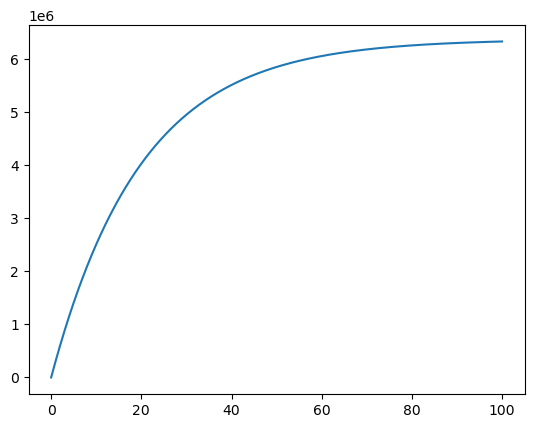

In [24]:
runtime = 100e-3  # simulate 100 ms
moose.reinit()
moose.start(runtime)
Vm = vm_tab.vector
t = np.arange(len(Vm)) * vm_tab.dt
plt.plot(t * 1e3, Vm * 1e3)

Since the time constant $\tau$ is 20 ms, 10 ms runtime could not really capture the charging timecourse in its entirety.

## Exercises
1. Modify the runtime to see the voltage reach a steady state.
1. What is the steady state voltage? Can you find a relation between the steady state voltage $Vm$, $Rm$ and $inject$?
1. What could be a realistic range for current injection ($inject$) for this cell?